In this notebook, we provide a sample test when applying fastMRI-trained (or -tuned) models to the Stanford set.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook/

import os
import sys
sys.path.insert(0,'/root/bart-0.6.00/python/')
import bart
os.environ['TOOLBOX_PATH'] = "/root/bart-0.6.00/"

import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join
import glob

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
from common.evaluate import *
from pytorch_msssim import ms_ssim
from common.evaluate import vifp_mscale
import pickle
from common.subsample import RandomMaskFunc, EquispacedMaskFunc

from DIP_UNET_models.unet_and_tv.train_unet import UnetMRIModel
from DIP_UNET_models.unet_and_tv.varnet import VariationalNetworkModel

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
import torch.nn as nn

from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu = 3
    torch.cuda.set_device(gpu)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor
devices = [torch.device("cuda:3"),
           torch.device("cuda:2"),
           torch.device("cuda:1"),
           torch.device("cuda:0"),]

num GPUs 4


# Load the data

In [22]:
with open('./stanford','rb') as fn: # refer to README for a link to this dataset
    data = pickle.load(fn)
print('data type:',type(data))
print('attributes of each data point:',data['ge1.h5'].keys())

data type: <class 'dict'>
attributes of each data point: dict_keys(['kspace', 'reconstruction_rss'])


# Evaluation and plot functions

In [3]:
def ssim1_(im1,im2):
    # im1: ground truth
    # im2: reconstruction
    im1 = (im1-im1.mean()) / im1.std()
    im1 *= im2.std()
    im1 += im2.mean()
    s = ssim(np.array([im1]),np.array([im2]))
    return s

In [20]:
def plot_(results,f):
    ctr = 1
    fig = plt.figure(figsize=(16,10))
    for key in results:
        if ctr == 1:
            ax = fig.add_subplot(2,3,ctr)
            ax.imshow(np.flip(results[key][f]['original'],axis=0),'gray')
            ax.set_title('ground truth')
            ax.axis('off')
            ctr += 1
        ax = fig.add_subplot(2,3,ctr)
        ax.imshow(np.flip(results[key][f]['reconstruction'],axis=0),'gray')
        ax.set_title(key + ' SSIM: %0.4f'%(results[key][f]['score']))
        ax.axis('off')
        ctr += 1
    plt.show()

# Pre-processing function
Since the data is rotated, we turn it into a consistent format similar to the original fastMRI samples.

In [4]:
from scipy.ndimage.interpolation import rotate,zoom
def rotatecomplex(a,angle,reshape=True):
    r = rotate(a.real,angle,reshape=reshape,mode='wrap')
    i = rotate(a.imag,angle,reshape=reshape,mode='wrap')
    return r+1j*i

# Reconstruction functions

In [5]:
def varnet_reconstruction(vmdl, ksp, mask, orig):
    masked_kspace, _ = transform.apply_mask(ksp.to(devices[0]), mask = mask.to(devices[0]))
    inp = masked_kspace.clone()

    with torch.no_grad():
        out = vmdl(inp[None,:].type(dtype).to(devices[0]),mask.type(torch.cuda.ByteTensor).to(devices[0]))
    rec = crop_center2(out[0].data.cpu().numpy(),320,320)
    Ssim = ssim1_(orig,rec)
    return rec, Ssim

In [6]:
def unet_reconstruction(umdl, ksp, mask, orig, need_crop=True):
    masked_kspace, _ = transform.apply_mask(ksp.to(devices[0]), mask = mask.type(dtype).to(devices[0]))
    
    ### fixed reconstruction from non-perturbed data
    sampled_image2 = transform.ifft2(masked_kspace)
    if need_crop:
        crop_size = (320, 320)
        sampled_image = transform.complex_center_crop(sampled_image2, crop_size)
    else:
        sampled_image = sampled_image2
    # Absolute value
    sampled_image = transform.complex_abs(sampled_image)
    # Apply Root-Sum-of-Squares if multicoil data
    sampled_image = transform.root_sum_of_squares(sampled_image)
    # Normalize input
    sampled_image, mean, std = transform.normalize_instance(sampled_image, eps=1e-11)
    sampled_image = sampled_image.clamp(-6, 6)
    inp = sampled_image.unsqueeze(0)
    out = umdl(inp.type(dtype).to(devices[0]))
    rec = out.data.cpu().numpy()[0]
    Ssim = ssim1_(orig,rec)
    return rec, Ssim

In [7]:
from pytorch_wavelets import DWTForward, DWTInverse
xfm = DWTForward(J=3, mode='zero', wave='db3').cuda(gpu)
def l1_reconstruction(ksp, mask, orig, num_iters = 1000, lam=1e-2,LR=1e-1,):
    unders, _ = transform.apply_mask(ksp, mask = mask)
    mse = torch.nn.MSELoss()
    x = Variable(torch.zeros(unders.shape[1:])).type(dtype).to(devices[0])
    x.requires_grad = True
    
    zpad = unders.data.cpu().numpy()
    zpad_complex = []
    for m in range(zpad.shape[0]):
        zpad_complex += [zpad[m,:,:,0]+1j*zpad[m,:,:,1]]
    zpad_complex = np.array(zpad_complex)
    zpad_complex.shape
    masked_complex_kspace = zpad_complex * np.array(ksp.shape[0]*[list(mask2d)]) # shape: (15, 640, 368)
    sens_maps = bart.bart(1, f'ecalib -d0 -m1', np.array([np.moveaxis(masked_complex_kspace,0,2)]))
    sens_maps = np.moveaxis(sens_maps[0],2,0)
    
    optimizer = torch.optim.SGD([x], lr=LR)
    S = transform.to_tensor(sens_maps).type(dtype).to(devices[0])
    L = []
    trL = []
    for i in range(num_iters):
        def closure():
            imgs = torch.zeros(S.shape).type(dtype).to(devices[0])
            for j,s in enumerate(S):
                imgs[j,:,:,0] = x[:,:,0] * s[:,:,0] - x[:,:,1] * s[:,:,1]
                imgs[j,:,:,1] = x[:,:,0] * s[:,:,1] + x[:,:,1] * s[:,:,0]
            optimizer.zero_grad()
            out,_ = transform.apply_mask(transform.fft2(imgs),mask=mask.to(devices[0]))
            Rx, Ux = xfm(x[None,:].permute(0,3,1,2))
            loss = mse( out , unders.type(dtype).to(devices[0]) ) + lam*torch.norm(Rx,p=1)
            loss.backward(retain_graph=True)
            if i % 100 == 0:
                print("iteration{} -- fitting loss: {}".format(i,loss.data),"\r",end='')
                L.append(loss.data.cpu().numpy()[np.newaxis][0])
            return loss
        loss = optimizer.step(closure)
    
    rec = center_crop(transform.complex_abs(x).data.cpu().numpy(),(320,320))
    Ssim = ssim1_(orig,rec)
    return rec, Ssim

In [8]:
def get_scale_factor(net,num_channels,in_size,ksp_tt,scale_out=1,scale_type="norm"): 
    ### get norm of deep decoder output
    # get net input, scaling of that is irrelevant
    shape = [1,num_channels, in_size[0], in_size[1]]
    ni = Variable(torch.zeros(shape)).type(dtype).to(devices[0])
    ni.data.uniform_()
    # generate random image
    try:
        out_chs = net( ni.type(dtype).to(devices[0]),scale_out=scale_out ).data.cpu().numpy()[0]
    except:
        out_chs = net( ni.type(dtype).to(devices[0]) ).data.cpu().numpy()[0]
    print(net(ni.type(dtype).to(devices[0])).shape)
    out_imgs = channels2imgs(out_chs)
    out_img_tt = transform.root_sum_of_squares( torch.tensor(out_imgs) , dim=0)

    ### get norm of least-squares reconstruction
    orig_tt = transform.ifft2(ksp_tt)           # Apply Inverse Fourier Transform to get the complex image
    orig_imgs_tt = transform.complex_abs(orig_tt)   # Compute absolute value to get a real image
    orig_img_tt = transform.root_sum_of_squares(orig_imgs_tt, dim=0)
    orig_img_np = orig_img_tt.cpu().numpy()
    
    if scale_type == "norm":
        s = np.linalg.norm(out_img_tt) / np.linalg.norm(orig_img_np)
    if scale_type == "mean":
        s = (out_img_tt.mean() / orig_img_np.mean()).numpy()[np.newaxis][0]
    return s,ni

In [9]:
def convdecoder_reconstruction(net, ksp, mask, mask1d, mask2d, orig):
    ### fix scaling for ConvDecoder
    scaling_factor,ni = get_scale_factor(net,
                                       num_channels,
                                       in_size,
                                       ksp,)
    slice_ksp_torchtensor1 = ksp.type(dtype).to(devices[0]) * scaling_factor
    masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor1, mask = mask.type(dtype).to(devices[0]))
    
    unders_measurement = Variable(masked_kspace[None,:])
    sampled_image2 = transform.ifft2(masked_kspace)
    measurement = slice_ksp_torchtensor1.unsqueeze(0).type(dtype).to(devices[0])
    lsimg = lsreconstruction(measurement)
    out = []
    for img in sampled_image2:
        out += [ img[:,:,0].data.cpu().numpy() , img[:,:,1].data.cpu().numpy() ]
    lsest = torch.tensor(np.array([out]))
    
    import copy
    scale_out,sover,pover,par_mse_n, par_mse_t, parni, pert_net = fitr(copy.deepcopy(net),
                                                                unders_measurement.to(devices[0]),
                                                                Variable(lsest).type(dtype).to(devices[0]),
                                                                mask2d,
                                                                num_iter=25000,
                                                                LR=0.008,
                                                                apply_f = forwardm,
                                                                lsimg = lsimg,
                                                                find_best=True,
                                                                net_input = ni.data.cpu().type(dtype).to(devices[0]),
                                                                OPTIMIZER = "adam"
                                                                )
    
    rec = data_consistency(pert_net, parni, mask1d, slice_ksp_torchtensor1.data.cpu())
    Ssim = ssim1_(orig,rec)
    return rec, Ssim

# Load pre-trained neural networks models

In [10]:
### Load a pre-trained varnet (trained on 4x accelerated multi-coil measurements of the FastMRI dataset)
class args():
    def __init__(self):
        self.num_cascades = 12
        self.pools = 4
        self.chans = 18
        self.sens_pools = 4
        self.sens_chans = 8
Args = args()
vmdl = VariationalNetworkModel(Args)

checkpoint = torch.load('/data/trained_e2e/best.ckpt', map_location='cpu')
vmdl.load_state_dict(checkpoint['state_dict'])

vmdl.to(devices[0]);
for i,cas in enumerate(vmdl.cascades):
    vmdl.cascades[i] = cas.to(devices[i//3])

In [11]:
### Load a pre-trained unet (trained on 4x accelerated multi-coil measurements of the FastMRI dataset)
class args():
    def __init__(self):
        self.num_pools = 4
        self.drop_prob = 0
        self.num_chans = 32
args = args()
umdl = UnetMRIModel(args)
umdl.cuda(gpu);

checkpoint = torch.load('./UNET_trained/epoch=49.ckpt', map_location='cpu')
umdl.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Sample test

In [12]:
results = {'VarNet':{},'Unet':{},'l1':{},'ConvDecoder':{}}

f = 'ge1.h5'
ctr = 1
print('{}-'.format(ctr),f)
ctr += 1
slice_ksp = data[f]['kspace'].copy()
for c,coil in enumerate(slice_ksp):
    slice_ksp[c,:,:] = rotatecomplex(coil,90) # the kspace is rotated, so werotate it back to the original format
slice_ksp_torchtensor = transform.to_tensor(slice_ksp) # Convert from numpy array to pytorch tensor
orig = np.rot90(data[f]['reconstruction_rss'])

### create a mask
desired_factor = 4 # desired under-sampling factor
undersampling_factor = 0
tolerance = 0.03
while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
    mask_func = RandomMaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
    masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
    mask1d = var_to_np(mask)[0,:,0]
    undersampling_factor = len(mask1d) / sum(mask1d)
mask1d = var_to_np(mask)[0,:,0]

mask2d = np.repeat(mask1d[None,:], slice_ksp_torchtensor.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp_torchtensor.shape[2]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()

### create a convdecoder
num_channels = 256 #256
num_layers = 8
strides = [1]*(num_layers-1)
in_size = [10,5]
kernel_size = 3
output_depth = slice_ksp_torchtensor.numpy().shape[0]*2
out_size =slice_ksp_torchtensor.numpy().shape[1:-1]

##### fit the network for reconstruction without perturbation #####
net = convdecoder(out_size,in_size,output_depth,
                     num_layers,strides,num_channels, act_fun = nn.ReLU(),
                     skips=False,need_sigmoid=False,bias=True, need_last = True,
                     kernel_size=kernel_size,upsample_mode="nearest").type(dtype).to(devices[0])

vrec, vs = varnet_reconstruction(vmdl, slice_ksp_torchtensor, mask, orig)
urec, us = unet_reconstruction(umdl, slice_ksp_torchtensor, mask, orig, need_crop=False)
lrec, ls = l1_reconstruction(slice_ksp_torchtensor, mask, orig, num_iters=1000,lam=1e-12,LR=1e5)
crec, cs = convdecoder_reconstruction(net, slice_ksp_torchtensor, mask, mask1d, mask2d, orig)

results['VarNet'][f] = {}
results['VarNet'][f]['original'] = orig
results['VarNet'][f]['reconstruction'] = vrec
results['VarNet'][f]['score'] = vs

results['Unet'][f] = {}
results['Unet'][f]['original'] = orig
results['Unet'][f]['reconstruction'] = urec
results['Unet'][f]['score'] = us

results['l1'][f] = {}
results['l1'][f]['original'] = orig
results['l1'][f]['reconstruction'] = lrec
results['l1'][f]['score'] = ls

results['ConvDecoder'][f] = {}
results['ConvDecoder'][f]['original'] = orig
results['ConvDecoder'][f]['reconstruction'] = crec
results['ConvDecoder'][f]['score'] = cs

#with open('*****','wb') as fn:
#    pickle.dump(results,fn)

1- ge1.h5
torch.Size([1, 16, 320, 320]) 121609416.0 
optimize with adam 0.008


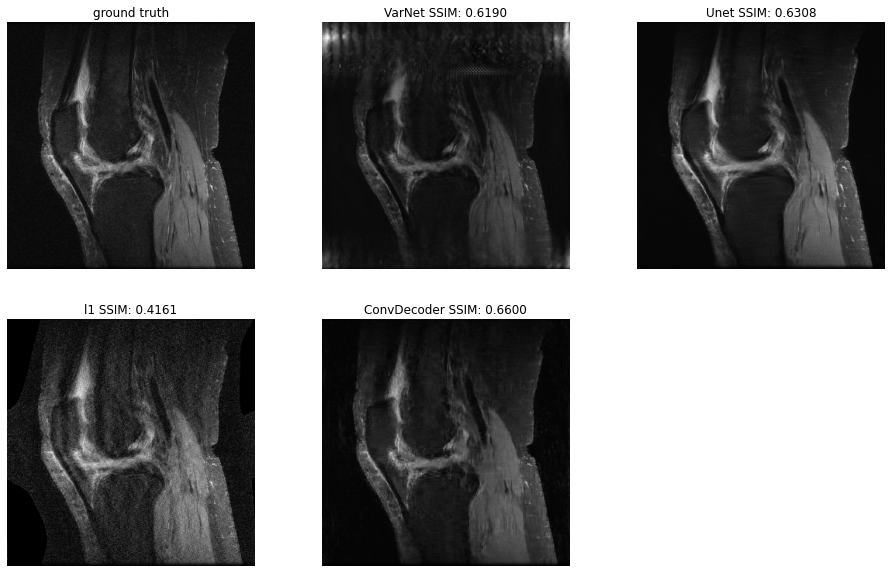

In [21]:
plot_(results,f)

# Mitigating the resolution shift effect for VarNet
Since VarNet is a $k$-space learning method, aside from the data distribution shift, it also suffers from the frequency resolution change. Therefore, we perform a simple test to mitigate this effect.

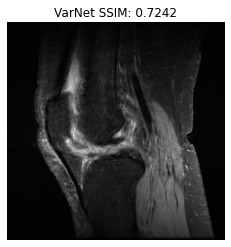

The frequency resolution matching enhances the performance of VarNet


In [25]:
slice_ksp = data[f]['kspace'].copy()
for c,coil in enumerate(slice_ksp):
    slice_ksp[c,:,:] = rotatecomplex(coil,90)
slice_ksp = slice_ksp.repeat(2, axis=1).repeat(2, axis=2)
slice_ksp_torchtensor = transform.to_tensor(slice_ksp) # Convert from numpy array to pytorch tensor
orig = np.rot90(data[f]['reconstruction_rss'])

### create a mask
desired_factor = 4 # desired under-sampling factor
undersampling_factor = 0
tolerance = 0.03
while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
    mask_func = RandomMaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
    masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
    mask1d = var_to_np(mask)[0,:,0]
    undersampling_factor = len(mask1d) / sum(mask1d)
mask1d = var_to_np(mask)[0,:,0]

mask2d = np.repeat(mask1d[None,:], slice_ksp_torchtensor.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp_torchtensor.shape[2]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()
vrec, vs = varnet_reconstruction(vmdl, slice_ksp_torchtensor, mask, orig)
plt.imshow(np.flip(vrec,axis=0),'gray')
plt.axis('off')
plt.title('VarNet SSIM: %0.4f'%(vs))
plt.show()
print('The frequency resolution matching enhances the performance of VarNet')